# Combining multiple quarters of *Kepler* data

## Learning Goals

By the end of this tutorial, you will: 

- Understand a *Kepler* Quarter.
- Understand how to download multiple quarters of data at once.
- Learn how to normalize *Kepler* data.
- Understand how to combine multiple quarters of data.


## Introduction

The [*Kepler*](https://archive.stsci.edu/kepler), [*K2*](https://archive.stsci.edu/k2), and [*TESS*](https://archive.stsci.edu/tess) telescopes observe stars for long periods of time. These long, time series observations are broken up into separate chunks, called quarters for the *Kepler* mission, campaigns for *K2*, and sectors for *TESS*.

Building light curves with as much data as is available is useful when searching for small signals, such as planetary transits or stellar pulsations. In this tutorial, we will learn how to use Lightkurve's tools to download and stitch together multiple quarters of *Kepler* observations.

It is recommended to first read the tutorial discussing how to use *Kepler* light curve products with Lightkurve. That tutorial will introduce you to some specifics of how *Kepler*, *K2*, and *TESS* make observations, and how these are displayed as light curves. It also introduces some important terms and concepts that are referred to in this tutorial.

This tutorial demonstrates how to access and combine multiple quarters of data from the *Kepler* space telescope, using the Lightkurve package.

When accessing *Kepler* data through MAST, it will be stored in three-month chunks, corresponding to a quarter of observations. By combining and normalizing these separate observations, you can form a single light curve that spans all observed quarters. Utilizing all of the data available is especially important when looking at repeating signals, such as planet transits and stellar oscillations.

We will use the *Kepler* mission as an example, but these tools are extensible to *TESS* and *K2* as well.

## Imports
This tutorial requires the [**Lightkurve**](http://docs.lightkurve.org/) package, which in turn uses `matplotlib` for plotting.

In [1]:
import lightkurve as lk
%matplotlib inline

## 1. What is a *Kepler* Quarter?

In order to search for planets around other stars, the *Kepler* space telescope performed near-continuous monitoring of a single field of view, from an Earth-trailing orbit. However, this posed a challenge. If the space telescope is trailing Earth and maintaining steady pointing, its solar panels would slowly receive less and less sunlight.

In order to make sure the solar panels remained oriented towards the Sun, *Kepler* performed quarterly rolls, one every 93 days. The infographic below helps visualize this, and shows the points in the orbit where the rolls took place.

After each roll, *Kepler* retained its fine-pointing at the same field of view. Because the camera rotated by 90 degrees, all of the target stars fell on different parts of the charge-coupled device (CCD) camera. This had an effect on the amount of flux recorded for the same star, because different CCD pixels have different sensitivities. The way in which the flux from the same stars was distributed on the CCD (called the point spread function or PSF) also changed after each roll, due to focus changes and other instrumental effects. As a result, the aperture mask set for a star had to be recomputed after each roll, and may capture slightly different amounts of flux. 

The data obtained between rolls is referred to as a quarter. While there are changes to the flux *systematics*, not much else changes quarter to quarter, and the majority of the target list remains identical. This means that, after removing systematic trends (such as was done for the presearch data conditioning simple aperture photometry (PDCSAP) flux), multiple quarters together can form one continuous observation.

<!-- ![](https://keplergo.arc.nasa.gov/images/program/Orbit_Mar5_09L.gif) -->
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Kepler_space_telescope_orbit.png/800px-Kepler_space_telescope_orbit.png" width="800">

*Figure*: Infographic showcasing the necessity of *Kepler*'s quarterly rolls and its Earth-trailing orbit. Source: [Kepler Science Center](https://keplergo.arc.nasa.gov/ExtendedMissionOverview.shtml).

**Note**:
Observations by *K2* and *TESS* are also broken down into chunks of a month or more, called campaigns (for *K2*) and sectors (for *TESS*). While not discussed in this tutorial, the tools below work for these data products as well.

## 2. Downloading Multiple `KeplerLightCurve` Objects at Once

To start, we can use Lightkurve's [search_lightcurve()](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) function to see what data are available for our target star on the [Mikulski Archive for Space Telescopes](https://archive.stsci.edu/kepler/) (MAST) archive. We will use the star [Kepler-8](http://www.openexoplanetcatalogue.com/planet/Kepler-8%20b/), a star somewhat larger than the Sun, and the host of a [hot Jupiter planet](https://en.wikipedia.org/wiki/Hot_Jupiter). 

In [2]:
search_result = lk.search_lightcurve("Kepler-8", author="Kepler", cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006922244,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006922244,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006922244,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006922244,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006922244,0.0
...,...,...,...,...,...,...
11,Kepler Quarter 11,2012,Kepler,1800,kplr006922244,0.0
12,Kepler Quarter 12,2012,Kepler,1800,kplr006922244,0.0


In this list, each row represents a different observing quarter, for a total of 18 quarters across four years. The **observation** column lists the *Kepler* Quarter. The **target_name** represents the *Kepler* Input Catalogue (KIC) ID of the target, and the **productFilename** column is the name of the FITS files downloaded from MAST. The **distance** column shows the separation on the sky between the searched coordinates and the downloaded objects — this is only relevant when searching for specific coordinates in the sky, and not when looking for individual objects.

Instead of downloading a single quarter using the [download()](https://docs.lightkurve.org/reference/api/lightkurve.SearchResult.download.html?highlight=download#lightkurve.SearchResult.download) function, we can use the [download_all()](https://docs.lightkurve.org/reference/api/lightkurve.SearchResult.download_all.html?highlight=download_all) function to access all 18 quarters at once (this might take a while).

In [3]:
lc_collection = search_result.download_all()
lc_collection

LightCurveCollection of 18 objects:
    0: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=0 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <KeplerLightCurv

All of the downloaded data are stored in a `LightCurveCollection`. This object acts as a wrapper for 18 separate `KeplerLightCurve` objects, listed above. 

We can access the `KeplerLightCurve` objects and interact with them as usual through the `LightCurveCollection`.

In [4]:
lc_Q4 = lc_collection[4] 
lc_Q4

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
352.37632485035283,———,———,0,-1.410670e-03,682.69125,190.13296,11914,4.3689148e+04,6.6459765e+00,1.6722699e+03,4.6767941e-01,———,———,0,682.60927,7.8001787e-05,190.36814,1.1752916e-04,682.69125,1.8638317e-04,190.13296,1.8306405e-04,9.8764673e-02,-1.7217098e-01
352.3967580484896,5.2490750e+04,8.0003128e+00,10000000000000,-1.411072e-03,682.69084,190.13270,11915,4.3698070e+04,6.6462421e+00,1.6698400e+03,4.6764868e-01,5.2490750e+04,8.0003128e+00,10000000000000,682.60900,7.7997785e-05,190.36777,1.1751152e-04,682.69084,1.8633612e-04,190.13270,1.8303936e-04,9.8700106e-02,-1.7229939e-01
352.4376244455707,5.2484055e+04,7.9999790e+00,10000,-1.411874e-03,682.69038,190.13302,11917,4.3694105e+04,6.6461620e+00,1.6731306e+03,4.6705514e-01,5.2484055e+04,7.9999790e+00,10000,682.60862,7.7994831e-05,190.36848,1.1754913e-04,682.69038,1.8634219e-04,190.13302,1.8301954e-04,9.8306537e-02,-1.7180158e-01
352.45805764463876,5.2491809e+04,8.0006199e+00,0,-1.412275e-03,682.69084,190.13257,11918,4.3698316e+04,6.6463132e+00,1.6741406e+03,4.6687824e-01,5.2491809e+04,8.0006199e+00,0,682.60872,7.7998680e-05,190.36792,1.1751390e-04,682.69084,1.8635279e-04,190.13257,1.8304381e-04,9.8410256e-02,-1.7202987e-01
352.4784908439324,5.2478277e+04,7.9992733e+00,0,-1.412676e-03,682.68949,190.13304,11919,4.3687648e+04,6.6459165e+00,1.6723815e+03,4.6764576e-01,5.2478277e+04,7.9992733e+00,0,682.60829,7.7993544e-05,190.36814,1.1756293e-04,682.68949,1.8641398e-04,190.13304,1.8308057e-04,9.8039381e-02,-1.7183834e-01
352.4989240434661,5.2475855e+04,7.9986620e+00,0,-1.413077e-03,682.69036,190.13318,11920,4.3686480e+04,6.6458707e+00,1.6734375e+03,4.6817183e-01,5.2475855e+04,7.9986620e+00,0,682.60852,7.7998702e-05,190.36875,1.1761812e-04,682.69036,1.8637831e-04,190.13318,1.8304847e-04,9.8102726e-02,-1.7151666e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442.1013323661464,5.2484648e+04,7.9707704e+00,0,-3.378539e-04,682.49086,190.34446,16305,4.3164066e+04,6.6142449e+00,1.4996798e+03,4.6686992e-01,5.2484648e+04,7.9707704e+00,0,682.42295,7.3321760e-05,190.68497,9.3209848e-05,682.49086,1.8497877e-04,190.34446,1.8690305e-04,-7.9818368e-02,1.3874538e-01


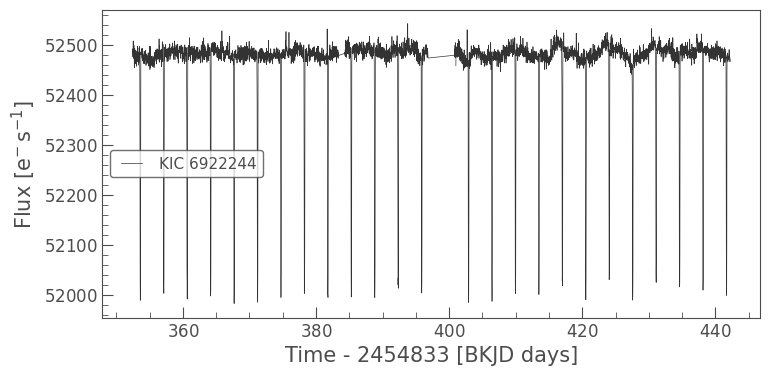

In [5]:
lc_Q4.plot();

#### Note:
The example given above also works for downloading target pixel files (TPFs). This will produce a `TargetPixelFileCollection` object instead.

## 3. Investigating the Data

Let's first have a look at how these observations differ from one another. We can plot the simple aperture photometry (SAP) flux of all of the observations in the [`LightCurveCollection`](https://docs.lightkurve.org/reference/api/lightkurve.collections.LightCurveCollection.html#lightkurve.collections.LightCurveCollection) to see how they compare.

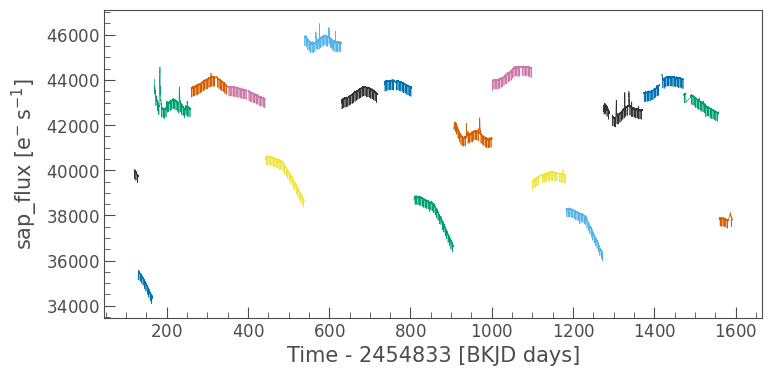

In [6]:
ax = lc_collection[0].plot(column='sap_flux', label=None)
for lc in lc_collection[1:]:
    lc.plot(ax=ax, column='sap_flux', label=None)

In the figure above, each quarter of data looks strikingly different, with global patterns repeating every four quarters as *Kepler* has made a full rotation.

The change in flux within each quarter is in part driven by changes in the telescope focus, which are caused by changes in the temperature of *Kepler*'s components as the spacecraft orbits the Sun. The changes are also caused by an effect called *differential velocity aberration* (DVA), which causes stars to drift over the course of a quarter, depending on their distance from the center of *Kepler*'s field of view.

While the figure above looks messy, all the systematic effects mentioned above are well understood, and have been detrended in the PDCSAP flux. For a more detailed overview, see the [*Kepler* Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), specifically: *Section 5. Ongoing Phenomena*.

## 4. Normalizing a Light Curve

If we want to see the actual variation of the targeted object over the course of these observations, the plot above isn't very useful to us. It is also not useful to have flux expressed in physical units, because it is affected by the observing conditions such as telescope focus and pointing (see above). 

Instead, it is a common practice to normalize light curves by dividing by their median value. This means that the median of the newly normalized light curve will be equal to 1, and that the relative size of signals in the observation (such as transits) will be maintained.

A normalization can be performed using the [normalize()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.normalize.html?highlight=normalize#lightkurve.LightCurve.normalize) method of a `KeplerLightCurve`, for example:

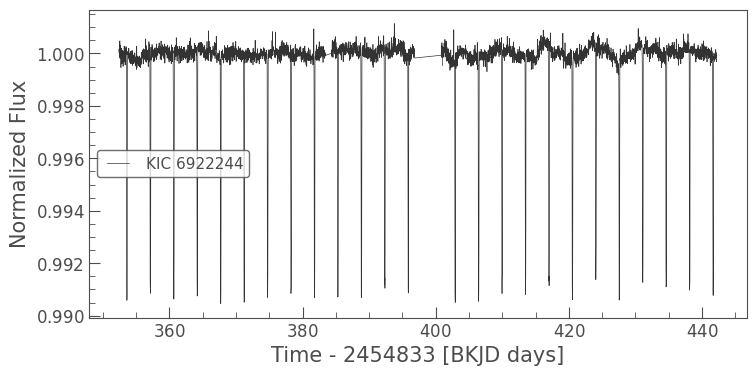

In [7]:
lc_collection[4].normalize().plot();

In the figure above, we have plotted the normalized PDCSAP flux for Quarter 4. The median normalized flux is at 1, and the transit depths lie around 0.991, indicating a 0.9% dip in brightness due to the planet transiting the star.

The `LightCurveCollection` also has a [plot()](https://docs.lightkurve.org/reference/api/lightkurve.FoldedLightCurve.plot.html?highlight=plot#lightkurve.FoldedLightCurve.plot) method. We can use it to plot the PDCSAP flux. The method automatically normalizes the flux in same way we did for a single quarter above.

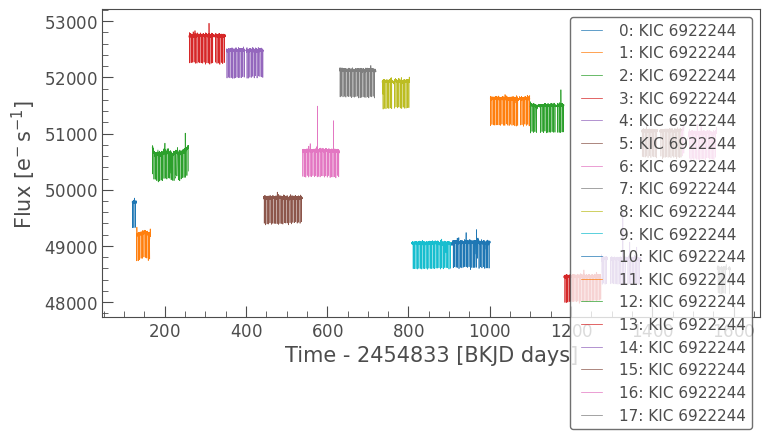

In [8]:
lc_collection.plot();

As you can see above, because we have normalized the data, all of the observations form a single consistent light curve.

## 5. Combining Multiple Observations into a Single Light Curve

Finally, we can combine these different light curves into a single `KeplerLightCurve` object. This is done using the `stitch()` method. This method concatenates all quarters in our `LightCurveCollection` together, and normalizes them at the same time, in the manner we saw above.

In [9]:
lc_stitched = lc_collection.stitch()
lc_stitched

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.53979406206781,1.0002389e+00,1.7835133e-04,0,1.641642e-03,676.76061,192.21102,568,4.0029211e+04,7.1942086e+00,1.3501000e+03,6.9019127e-01,4.9790078e+04,8.8780060e+00,0,———,———,———,———,676.76061,2.4257520e-04,192.21102,2.8915040e-04,-6.1361594e-03,1.2139007e-02
120.56022845695406,1.0000123e+00,1.7952095e-04,0,1.642437e-03,676.76010,192.21002,569,4.0014566e+04,7.1924801e+00,1.3488469e+03,6.8939346e-01,4.9778801e+04,8.9362278e+00,0,———,———,———,———,676.76010,2.4263318e-04,192.21002,2.8926603e-04,-6.3053877e-03,1.1505429e-02
120.58066275172314,9.9970073e-01,1.7981241e-04,0,1.643232e-03,676.76146,192.20988,570,4.0000406e+04,7.1918778e+00,1.3513733e+03,6.8988037e-01,4.9763289e+04,8.9507360e+00,0,———,———,———,———,676.76146,2.4270279e-04,192.20988,2.8932444e-04,-5.5118860e-03,1.1369802e-02
120.60109724637005,1.0002698e+00,1.7900635e-04,0,1.644026e-03,676.76139,192.20938,571,4.0018668e+04,7.1936789e+00,1.3461132e+03,6.8999070e-01,4.9791617e+04,8.9106121e+00,0,———,———,———,———,676.76139,2.4260787e-04,192.20938,2.8922342e-04,-5.5788676e-03,1.0246177e-02
120.62153164102347,1.0001223e+00,1.7974019e-04,0,1.644821e-03,676.76213,192.20898,572,4.0008617e+04,7.1923513e+00,1.3499850e+03,6.9054097e-01,4.9784277e+04,8.9471407e+00,0,———,———,———,———,676.76213,2.4259168e-04,192.20898,2.8918759e-04,-4.6821944e-03,1.0072310e-02
120.6419659354433,9.9984479e-01,1.7990815e-04,0,1.645615e-03,676.76170,192.20871,573,3.9994742e+04,7.1914024e+00,1.3490905e+03,6.8729931e-01,4.9770461e+04,8.9555016e+00,0,———,———,———,———,676.76170,2.4268354e-04,192.20871,2.8930244e-04,-4.2848983e-03,9.4073853e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590.900002857561,9.9988633e-01,1.8179342e-04,0,1.018638e-03,676.80148,192.10108,72526,3.7831559e+04,6.9085450e+00,1.2787664e+03,5.9414190e-01,4.8594551e+04,8.8351736e+00,0,676.75930,1.4916631e-04,192.31896,1.9152595e-04,676.80148,2.5232948e-04,192.10108,2.5263420e-04,-4.0509203e-03,1.4821382e-02


This returns a single `KeplerLightCurve`! It is in all ways identical to `KeplerLightCurve` of a single quarter, just longer. We can plot it the usual way.

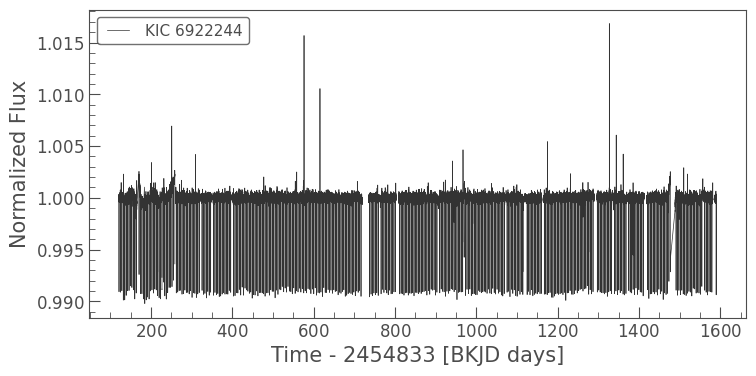

In [10]:
lc_stitched.plot();

In this final normalized light curve, the interesting observational features of the star are more clear. Specifically: repeating transits that can be used to [characterize planets](https://docs.lightkurve.org/tutorials/02-recover-a-planet.html) and a noisy stellar flux that can be used to study brightness variability through [asteroseismology](http://docs.lightkurve.org/tutorials/02-asteroseismology.html).

Normalizing individual *Kepler* Quarters before combining them to form a single light curve isn't the only way to make sure different quarters are consistent with one another. For a breakdown of other available methods and their benefits, see *Section 6. Stitching Kepler Quarters Together* in [Kinemuchi et al. 2012](https://arxiv.org/pdf/1207.3093.pdf).

## About this Notebook

**Authors:** Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-15

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [11]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
